### Laboratorium 6 - część 2/2

W tej części zajmiesz się wykorzystaniem punktów kluczowych do dwóch popularnych zadań: wyszukiwania obszarów podobnych oraz łączenia obrazów (_image stitching_).

Przeczytaj treść całej instrukcji przed przystąpieniem do działania!

In [299]:
from typing import List

import cv2
import numpy as np
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt

#### Zadanie 3

Dane są obrazy `coke` i `table`. Wykorzystaj metodologię parowania punktów kluczowych do znalezienia wystąpienia puszki z Colą na stole. To zadanie jest podzielone na kilka kamieni milowych - czytaj dalej.

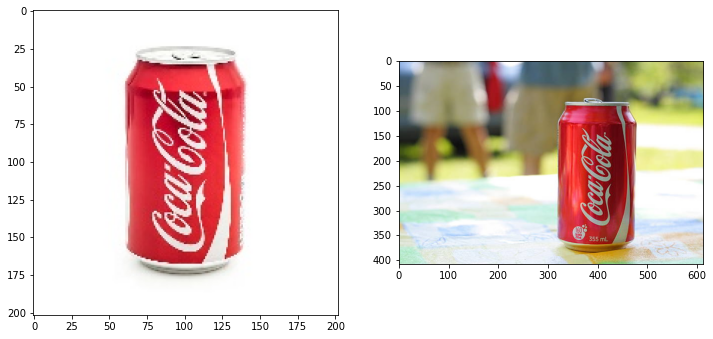

In [3]:
coke = cv2.imread('data/coke.jpg')
table = cv2.imread('data/coke-table.jpg')
f, (a1, a2) = plt.subplots(1, 2, figsize=(12,12))
a1.imshow(coke[..., ::-1]);
a2.imshow(table[..., ::-1]);

##### Zadanie 3a

Wykonaj detekcję punktów kluczowych i ich parowanie z użyciem dowolnego matchera. Wykonaj filtrację znalezionych par po dystansie - co obserwujesz, zmieniając próg?

In [28]:
def plot_distance_matching(src_img: np.array, target_img: np.array, distance_ths: List[float]):
    sift = cv2.SIFT_create()
    kp1, ds1 = sift.detectAndCompute(src_img, mask=None)
    kp2, ds2 = sift.detectAndCompute(target_img, mask=None)

    matcher = cv2.BFMatcher_create()
    best_matches = np.array(matcher.match(ds1, ds2))
    distances = np.array([match.distance for match in best_matches])

    # Plot matches
    fig, axes = plt.subplots(3, 3, figsize=(25, 15))

    for ax, distance_th in zip(axes.flatten(), distance_ths):
        th_matches = best_matches[distances < distance_th]

        img_matches = cv2.drawMatches(src_img, kp1, target_img, kp2, th_matches, None, matchColor=(0,255,0), singlePointColor=(0,0,255))
        ax.imshow(img_matches[..., ::-1])
        ax.axis("off")
        ax.set_title(f"Max distance={distance_th}")

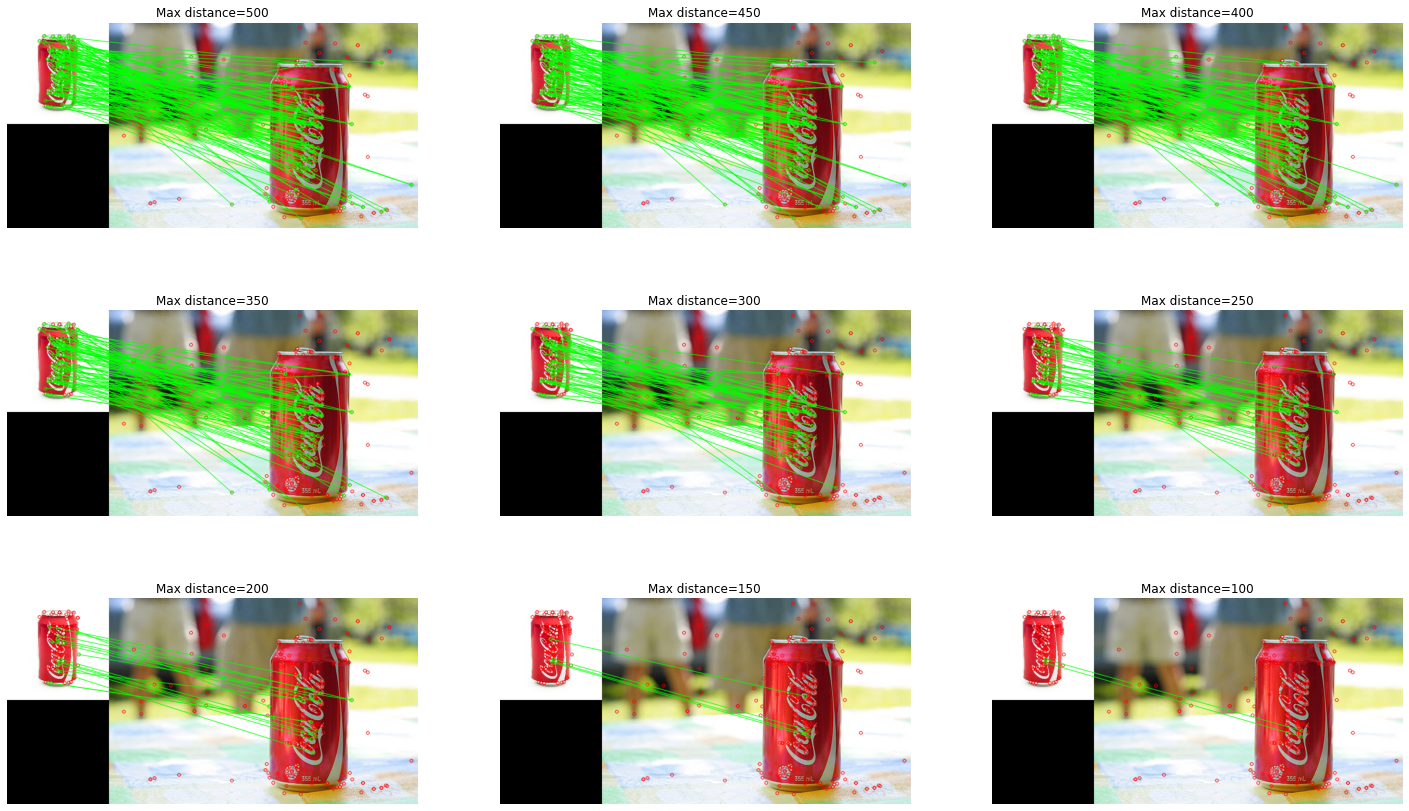

In [29]:
plot_distance_matching(coke, table, [500, 450, 400, 350, 300, 250, 200, 150, 100])

##### Zadanie 3b

Powtórz detekcję z użyciem k-najlepszych wyników (dla niewielkiego k, np. 2 lub 3). Zaproponuj prosty sposób wykrywania sytuacji, w których jeden punkt jest podobnie bliski innym i użyj go do odfiltrowania wyników, tak aby pozostawić te bardziej unikatowe dopasowania. *Czy unikatowe znaczy dobre?*

In [159]:
class ChamferFilter:
    """
    Chamfer distance filtering
    
    Compute all pair chamfer distance between best matches k-sets
    If two k-sets are closer to each other than the specified threshold
    filter out the one with larger minimal matching distance.
    """

    def __init__(self, keypoints, best_k_matches):
        self.keypoints = keypoints
        self.best_k_matches = best_k_matches

        self.chamfers = self._precompute_chamfers()
        self.distances = self._precompute_distances()

    def _precompute_chamfers(self):
        pointsets = np.array([
            [self.keypoints[match.trainIdx].pt for match in matches] 
            for matches in self.best_k_matches
        ])

        chamfers = np.zeros((len(pointsets), len(pointsets)))

        for i in range(len(pointsets)):
            for j in range(i + 1, len(pointsets)):
                chamfer = self._chamfer_distance(pointsets[i], pointsets[j])
                chamfers[i, j] = chamfer
                chamfers[j, i] = chamfer

        return chamfers

    def _precompute_distances(self):
        distances = np.array([
            min([match.distance for match in matches]) 
            for matches in self.best_k_matches
        ])

        return distances

    def _chamfer_distance(self, x, y):
        x_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree').fit(x)
        min_y_to_x = x_nn.kneighbors(y)[0]
        y_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree').fit(y)
        min_x_to_y = y_nn.kneighbors(x)[0]
        chamfer_dist = np.mean(min_y_to_x) + np.mean(min_x_to_y)
        
        return chamfer_dist

    def filter(self, threshold: float):

        filter_mask = np.ones(len(self.best_k_matches)).astype(bool)
        distance_order = np.argsort(self.distances)

        for i in distance_order:
            if filter_mask[i]:

                for j in distance_order[i + 1:]:
                    if self.chamfers[i, j] < threshold:
                        filter_mask[j] = False

        return self.best_k_matches[filter_mask]

In [160]:
def plot_knn_matching(src_img: np.array, target_img: np.array, filter_ths: List[float], k: int):
    sift = cv2.SIFT_create()
    kp1, ds1 = sift.detectAndCompute(src_img, mask=None)
    kp2, ds2 = sift.detectAndCompute(target_img, mask=None)

    matcher = cv2.BFMatcher_create()
    best_k_matches = np.array(matcher.knnMatch(ds1, ds2, k=k))

    chamfer_filter = ChamferFilter(kp2, best_k_matches)

    # Plot matches
    fig, axes = plt.subplots(3, 3, figsize=(25, 15))

    for ax, filter_th in zip(axes.flatten(), filter_ths):
        
        filtered_k_best_matches = chamfer_filter.filter(filter_th)
        img_matches = cv2.drawMatchesKnn(src_img, kp1, target_img, kp2, filtered_k_best_matches, None, matchColor=(0,255,0), singlePointColor=(0,0,255))
        
        ax.imshow(img_matches[..., ::-1])
        ax.axis("off")
        ax.set_title(f"Chamfer filter threshold={filter_th}")

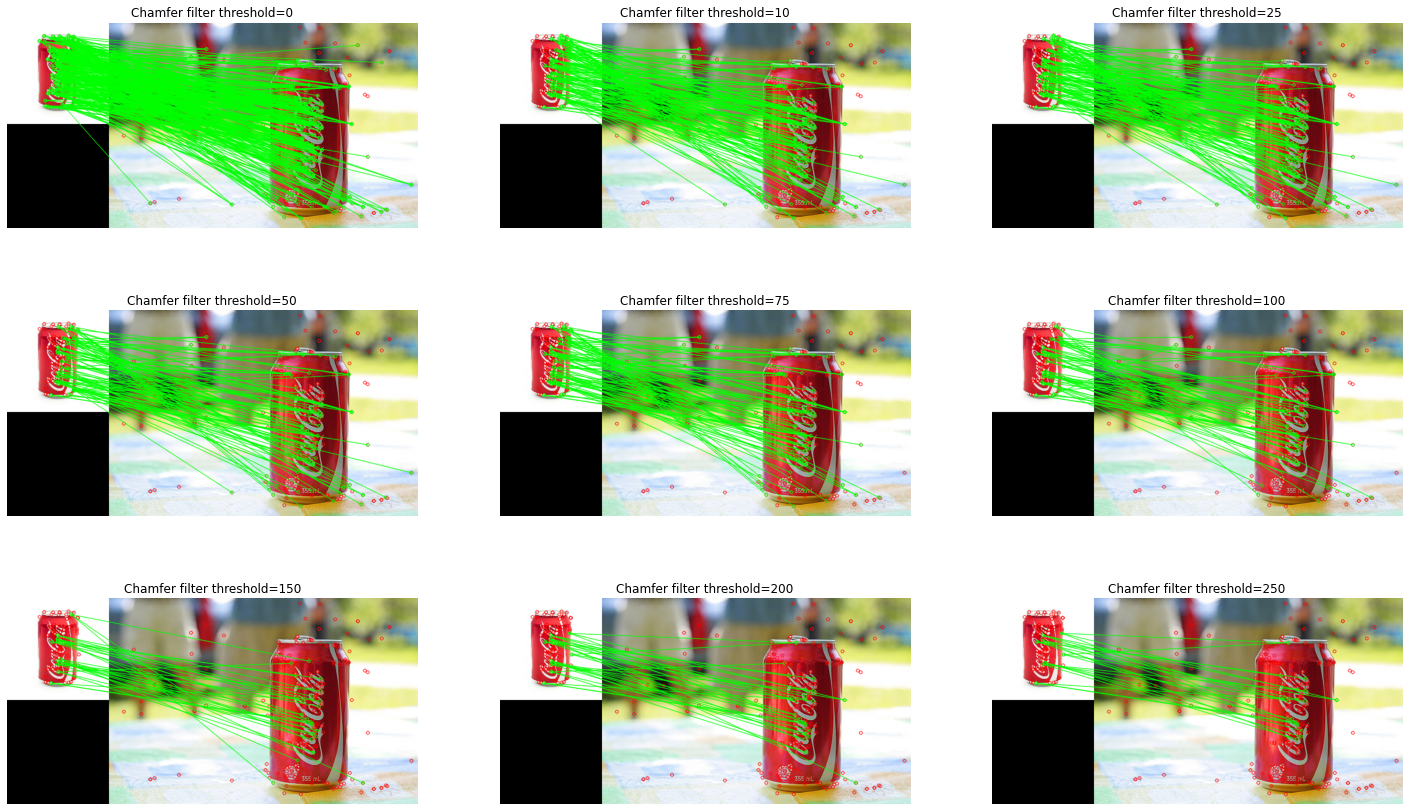

In [161]:
plot_knn_matching(coke, table, [0, 10, 25, 50, 75, 100, 150, 200, 250], k=3)

##### Zadanie 3c

Znajdź transformację geometryczną dla par dopasowanych punktów, tak aby przekształcić `coke` (*train*) do geometrii `table` (query). Zademonstruj poprawność, zestawiając obok siebie przekształconą wersję `coke` oraz oryginalny `table`, bądź nanosząc jedno na drugie. Zidentyfikuj punkty, które znaleziona transformacja przekształca "dobrze", tzn. ich współrzędne po przekształceniu leżą w pobliżu odpowiadających im punktów z drugiego obrazu; nanieś je na obraz.

*Jak na wyniki wpływa wykrycie większej lub mniejszej liczby punktów kluczowych na etapie SIFT? W jakim stopniu wstępna filtracja poprawia rezultaty? Jak działa i jaką rolę w procesie parowania odgrywa RANSAC?*

*\"Na piątkę\"*: znajdź rejon zainteresowania (RoI), tj. prostokąt otaczający zidentyfikowane właśnie punkty, a następnie oblicz błąd średniokwadratowy między obrazami w tym rejonie (albo dowolną miarę podobieństwa). Bonus: użyj [`cv2.convexHull`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga014b28e56cb8854c0de4a211cb2be656) do narysowania maski wybierającej tylko piksele znajdujące się wewnątrz wielokąta otaczającego "dobrze" dopasowane punkty, by liczyć miarę podobieństwa jedynie wewnątrz tego obszaru.

In [304]:
def plot_distance_filtered_warping(src_img: np.array, target_img: np.array, distance_ths: List[float]):

    sift = cv2.SIFT_create()
    kp1, ds1 = sift.detectAndCompute(src_img, mask=None)
    kp2, ds2 = sift.detectAndCompute(target_img, mask=None)

    matcher = cv2.BFMatcher_create()
    best_matches = np.array(matcher.match(ds1, ds2))
    distances = np.array([match.distance for match in best_matches])

    best_kp1_coords = np.array([kp1[match.queryIdx].pt for match in best_matches]) 
    best_kp2_coords = np.array([kp2[match.trainIdx].pt for match in best_matches]) 

    # Plot matches
    fig, axes = plt.subplots(7, 4, figsize=(25, 35))

    for ax, distance_th in zip(axes, distance_ths):

        # Filter by distances
        th_matches = best_matches[distances < distance_th]
        th_kp1_coords = best_kp1_coords[distances < distance_th]
        th_kp2_coords = best_kp2_coords[distances < distance_th]
        
        # Find homography and warp
        H, W, _ = target_img.shape 
        homography, _ = cv2.findHomography(th_kp1_coords, th_kp2_coords, cv2.RANSAC, 5.0)
        warped_src = cv2.warpPerspective(src_img, homography, dsize=(W, H))
        
        points = np.c_[th_kp1_coords, np.ones(len(th_kp1_coords))[:, None]]
        warped_points = (homography @ points.T).T[:, :2]

        # Draw source and target points
        matched_blend = cv2.addWeighted(target_img[..., ::-1], 0.5, warped_src[..., ::-1], 0.5, 0)
        well_matched_blend = cv2.addWeighted(target_img[..., ::-1], 0.5, warped_src[..., ::-1], 0.5, 0)
        well_matched = []

        for p1, p2 in zip(th_kp2_coords, warped_points):
            p1 = p1.astype(np.int32)
            p2 = p2.astype(np.int32)

            cv2.circle(matched_blend, p1, radius=4, color=(255, 120, 0), thickness=-1)
            cv2.circle(matched_blend, p2, radius=4, color=(0, 0, 255), thickness=-1)
            cv2.line(matched_blend, p1, p2, color=(0, 255, 0), thickness=1)

            if np.linalg.norm(p1 - p2) < 50:
                well_matched.append(p2)
                cv2.circle(well_matched_blend, p1, radius=4, color=(255, 120, 0), thickness=-1)
                cv2.circle(well_matched_blend, p2, radius=4, color=(0, 0, 255), thickness=-1)
                cv2.line(well_matched_blend, p1, p2, color=(0, 255, 0), thickness=2)

        # Convex hull and mse
        hull = np.array(cv2.convexHull(np.array(well_matched)))
        cv2.drawContours(well_matched_blend, [hull], 0, color=(0, 0, 0), thickness=2)

        hull_mask = np.zeros_like(well_matched_blend)
        hull_mask = cv2.drawContours(hull_mask, [hull], 0, color=(255, 255, 255), thickness=-1)
        hull_mse = np.mean((target_img * hull_mask) ** 2 - (warped_src * hull_mask) ** 2)

        # Plot results
        img_matches = cv2.drawMatches(src_img, kp1, target_img, kp2, th_matches, None, matchColor=(0,255,0), singlePointColor=(0,0,255))

        ax[0].imshow(img_matches[..., ::-1])
        ax[1].imshow(warped_src[..., ::-1])
        ax[2].imshow(matched_blend)
        ax[3].imshow(well_matched_blend)

        ax[0].axis("off")
        ax[1].axis("off")
        ax[2].axis("off")
        ax[3].axis("off")
        
        ax[0].set_title(f"Filtered: Max distance={distance_th}")
        ax[1].set_title("Warped source")
        ax[2].set_title(f"All matched points: {len(warped_points)}\nOrange - target, Blue - warped source")
        ax[3].set_title(f"Well matched points: {len(well_matched)}\nHull MSE: {hull_mse}")

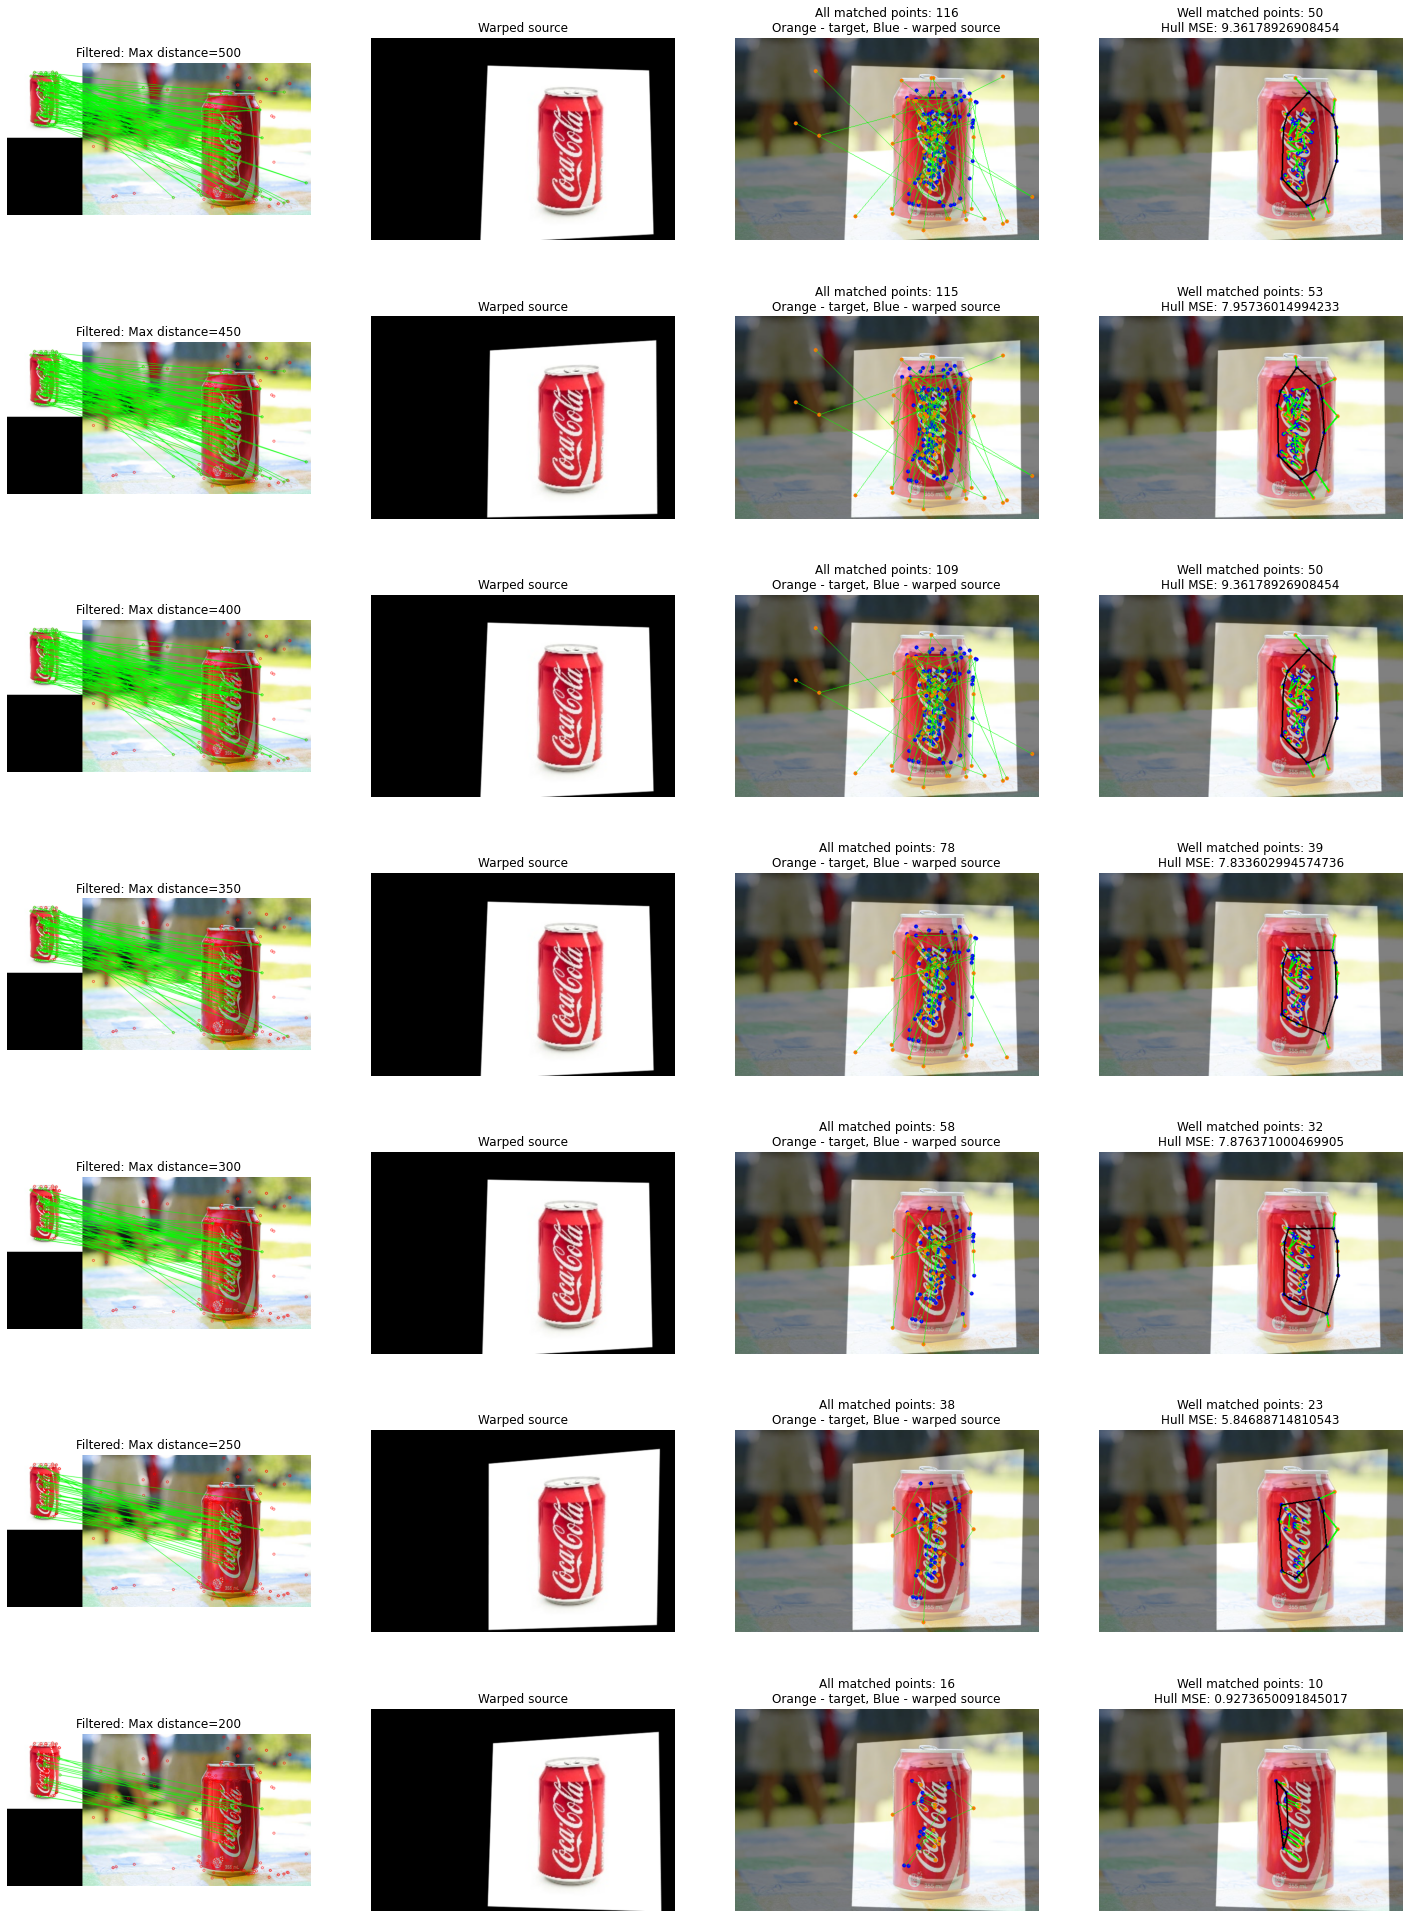

In [305]:
plot_distance_filtered_warping(coke, table, [500, 450, 400, 350, 300, 250, 200])

#### Zadanie 4

Wykonaj serię zdjęć dowolnej wybranej przez siebie **statycznej** sceny. Może to być zupełnie dowolny widok o dowolnej skali: panorama miasta, swojego pokoju, powierzchni biurka - ważne, by pozyskane obrazy zawierały jakieś punkty charakterystyczne. (Może posiadasz jakieś ciekawe dane z własnego projektu, które możesz tu wykorzystać?)

Wykonaj 4-5 zdjęć, spośród których pierwsze (nazwij je `base`) niech przedstawia \"główny\" widok sceny, a pozostałe (o nazwie `offset_{index}`) niech cechują się coraz większym przesunięciem kamery względem `base`. Proponowane różnice:
* nieznaczne przesunięcie (o połowę-2/3 szerokości klatki)
* większe przesunięcie (o 3/4-4/5 szerokości)
* przesunięcie z rotacją w osi kamery
* (jeśli to możliwe) przybliżenie/oddalenie kamery.

Celem zadania będzie przetestowanie możliwości detekcji i parowania punktów kluczowych w celu łączenia (_stitching_) obrazów. Wykorzystaj algorytmy opracowane do realizacji zadania 3 (zwłaszcza 3c) w celu przekształcania obrazów `offset_x` do geometrii `base`. Upewnij się, że wymiary tworzonych w ten sposób obrazów są wystarczające do zmieszczenia obu składowych. Jeśli rozwiązujesz zadanie 3c w wariancie _\"na piątkę\"_, użyj tej metody oceny również w tym zadaniu.

*Czy każdą parę `offset_i`-`base` udało się połączyć? Jaka jest jakość dopasowania? Jeśli dla którejś pary algorytm zawiódł - dlaczego?*